In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

from sat_metropolis import smt, mcmc, sat, utils

In [2]:
south_head = pd.read_csv("south_head.csv")
south_head

,,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,35-39 years,40-44 years,45-49 years,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85-89 years,90 years and over
0,Male,3,6,6,12,9,3,9,9,6,6,15,6,3,6,3,3,0,0,0
1,Female,6,0,3,6,3,6,3,9,3,6,9,6,9,3,3,3,0,0,0
2,Total,15,3,12,15,15,12,9,18,9,12,21,12,12,12,6,0,0,0,0


In [3]:
# Assumption, all bit-vectors are of the same size
num_bits = 5
num_vars = 19*2
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)

#Add contraints
numpy_data = south_head.to_numpy()[:,1:]

for i in range(19):
    g.add(ULE(x[i],numpy_data[0,i]+2))
    if(numpy_data[0,i]>0):
        g.add(ULE(numpy_data[0,i]-2,x[i]))

    g.add(ULE(x[i+19],numpy_data[1,i]+2))
    if(numpy_data[1,i]>0):
        g.add(ULE(numpy_data[1,i]-2,x[i+19]))

    g.add(ULE(x[i+19] + x[i], numpy_data[2,i]+2))
    if(numpy_data[2,i]>0):
        g.add(ULE(numpy_data[2,i]-2,x[i+19]+x[i]))

In [4]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='spur',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4)

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	638/638/0
independent support size:  	0
clauses (all/long/binary/unit): 2008/1178/742/88
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	787 MB

STAGE #1: Build the initial partial assignments
STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	787 MB

Sample #1 of 171 is already a complete assignment.  Continuing...
Completing sample #2 of 171 which has 8 variables unset and 87 samples.
Completing sample #3 of 171 which has 9 variables unset and 77 samples.
Completing sample #4 of 171 which has 5 variables unset and 304 samples.
Completing sample #5 of 171 which has 4 varia

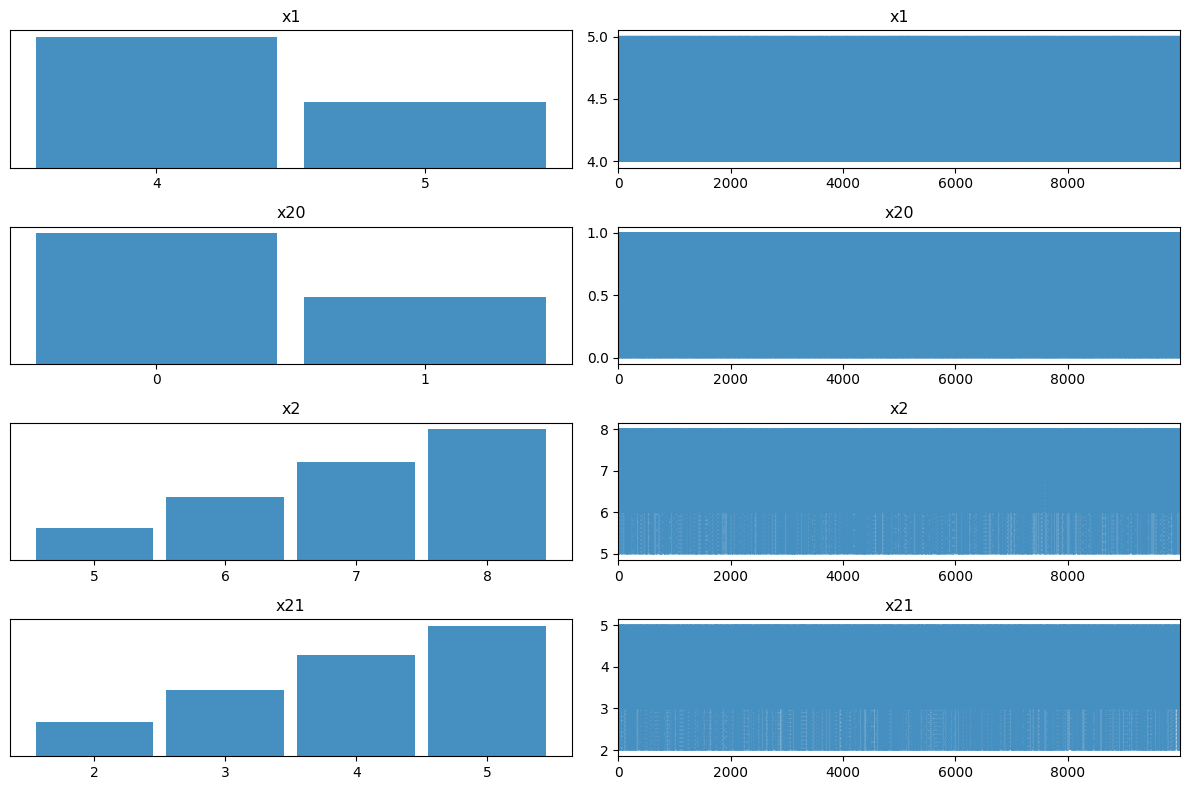

In [5]:
# Plot the posterior
az.plot_trace(trace, var_names=['x1', 'x20', 'x2', 'x21']);
plt.savefig('spur_trace_plot_nz_db.png', dpi=150);

In [6]:
# Diagnostics
az.summary(trace)

/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,5.000,0.000,5.0,5.0,0.000,NaN,40000.0,40000.0,NaN
x1,4.334,0.472,4.0,5.0,0.002,0.001,39308.0,39308.0,1.0
x2,7.009,0.998,5.0,8.0,0.005,0.003,39525.0,40000.0,1.0
x3,10.977,0.989,10.0,13.0,0.005,0.003,40208.0,39876.0,1.0
x4,9.987,1.008,8.0,11.0,0.005,0.003,39884.0,39900.0,1.0
x5,4.027,0.993,2.0,5.0,0.005,0.003,40022.0,38136.0,1.0
x6,7.999,0.987,7.0,10.0,0.005,0.003,38907.0,39518.0,1.0
x7,9.013,1.295,7.0,11.0,0.006,0.003,40350.0,39978.0,1.0
x8,5.990,1.303,4.0,8.0,0.007,0.003,39429.0,38944.0,1.0
x9,5.999,1.298,4.0,8.0,0.006,0.003,40068.0,39686.0,1.0
